<h1><center> Network (Data) Science and Assignment 2 Support </center></h1>

Assignment 2 will combine supervised learning on networks with an essay to reflect on the ethical implications of data science. In this notebook you can practice with network analysis (community detection and link prediction). 

You can also use parts of this notebook as a starting point for your assigment: the final part of this notebook can help you to import network data, perform feature engineering and output your predictions.

<h2> Community detection </h2>

The first task we will consider is community detection. This is one example of unsupervised learning with network data. Community detection methods are helpful to detect communities (also known as clusters of modules) based on network structure, such as strongly connected groups of nodes: groups of friends in social, academic sub-communities in co-authorship networks, groups of related web-pages, groups of functionally similar units in metabolic netowrks (...). 

Here you'll find some portions of code that you can use to perform Community Detection analysis (discussed in Lecture 8). We're going to use the example of the Zachary's Karate Club introduced in Lecture 8. You can find more details about this example [here](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

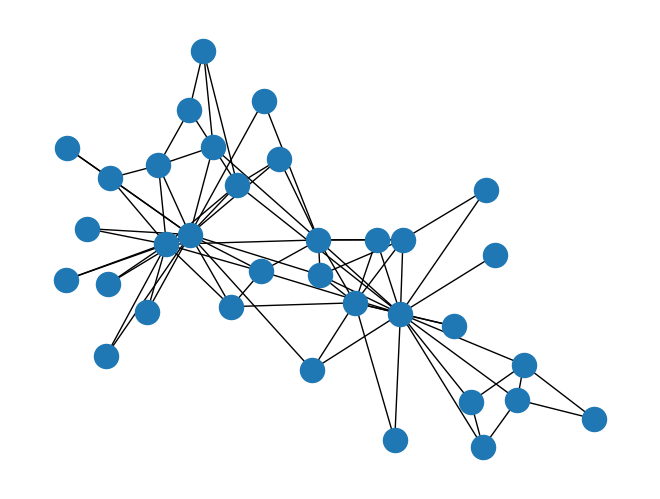

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Generate a network (NetworkX already provides a method to extract the Zachary's Karate Club data)
G = nx.karate_club_graph()

# Lets displace nodes following a Directed Force algorithm (remember Lecture 4, on Data Viz, and Lab 2 Aux)
pos = nx.spring_layout(G)

# Draw the original graph
nx.draw(G, pos=pos)  

We're now goign to play with an implementation of Community Detection offered by NetworkX, which will follow the same principles of Modularity Maximization lectured in [Lecture 8](https://canvas.uva.nl/courses/39320/files/9394934?module_item_id=1810179).

You can find extra details about function <code>greedy_modularity_communities</code> [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html).

In [2]:
from networkx.algorithms.community import greedy_modularity_communities

#the function will return a partition of nodes
c = list(greedy_modularity_communities(G, resolution=0.8))

print(c)

#we can inspecte the first element of the partition (e.g., nodes on community 1)
sorted(c[0])

[frozenset({0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21}), frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})]


[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 16, 17, 19, 21]

**Q1: How many communities are identified? What is the impact of parameter resolution (now set to 0.8) on this value?**

(check the  greedy_modularity_communities documentation pointed above)

**Q2: Can you plot the network with nodes colores based on communities?**

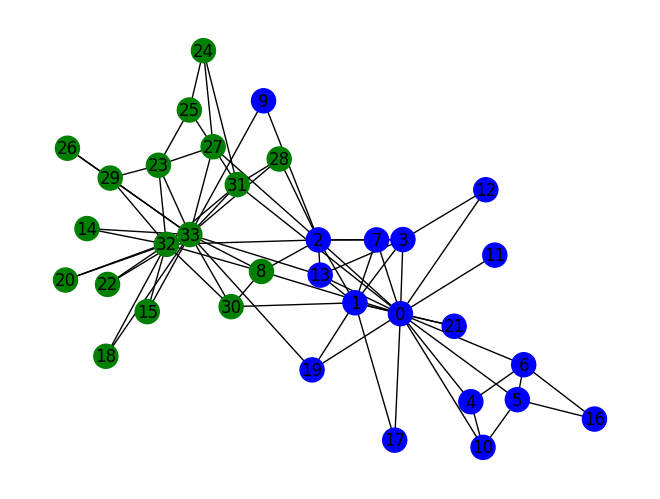

In [3]:
color_map = []
for node in G.nodes:
    if node in c[0]:
        color_map.append('blue')
    else:
        color_map.append('green')
        
nx.draw(G, node_color=color_map, with_labels=True, pos=pos)


<h2> Link Prediction - Auxiliary functions Assignment 2 </h2>

The next task we consider is link prediction. Link prediction will be at the core of your [Assignment 2](https://canvas.uva.nl/courses/39320/assignments/453832). 

Predicting links on a network is fundamental to predict future connections in social networks or discover hidden connections in incomplete network data. You can find more info about link prediction on [Wikipedia](https://en.wikipedia.org/wiki/Link_prediction).


There are many approaches to link prediction, from simpler ones (based on heuristics and network similarity measures, also called topology-based approaches) to more complex ones (based on graph embeddings and deep learning). 

The supervised learning methods you learned so far can also be used to perform link prediction. In your Assignment you should use supervised learning, in particular the techniques discussed in the course, to tackle the problem of link prediction. In the example below you will try to predict links in the Karate Club network.

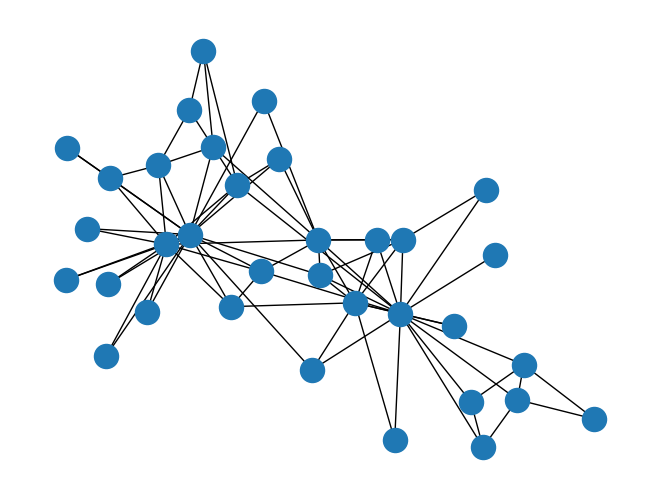

In [4]:
# Importing and exporting network data
import pandas as pd

# We will start by importing the Karate Club network from an edgelist
# This example can be useful for you to import the network data used in Assignment 2

G1 = nx.read_edgelist("karateclub.edgelist", data=False, nodetype = int, delimiter=',') # import
nx.draw(G1, pos=pos)

Above we are creating a network by importing a list of edges in the exact same format of edges_train.edgelist for Assignment 2.

The network has  34  nodes
The network has  69  edges


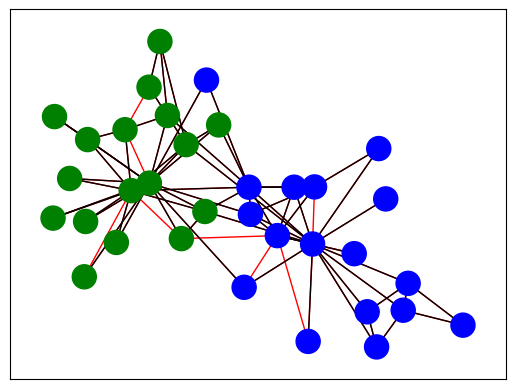

In [5]:
# We will now create a training set by removing nEdgesRemove random edges from the network above
# 10 edges will be removed
nEdgesRemove = 10

# Sample random edges
allEdges = np.array(G1.edges)
np.random.seed(seed=42)
selectEdges = np.random.choice(np.arange(allEdges.shape[0]), nEdgesRemove)
edgesToRemove = allEdges[selectEdges]

# Create new graph (H) without selected edges
H = G1.copy()
H.remove_edges_from(edgesToRemove)

# Visualize the links that were removed (in red)
# Use the same colors as defined above to color communities
nx.draw_networkx_nodes(G, node_color=color_map, pos=pos)

nx.draw_networkx_edges(G, pos, edge_color='red')
nx.draw_networkx_edges(H, pos, edge_color='black')

#Compute number of nodes in the network
N = len(list(H.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(H.edges))
print("The network has ", E, " edges")

After importing the network the next task is to define the features that seem important to predict the occurence of links.

This is the step where feature engineering can take place. We are using [preferencial attachment](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment) as one feature to infer links. This might not be the most interesting feature to predict links in this social network... Other possible features can be constructed by metrics you can learn about in the NetworkX documentation ([here](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html)).

**Q2: Which other featues can you use? Adapt function *getFeature* to consider other feastures associated with each edge.**

In [6]:
# Use Preferential Attachment between nodes as a feature
pa = np.zeros((N,N))

preds = nx.preferential_attachment(H, [(i,j) for i in range(N) for j in range(N)])
for u, v, p in preds:
    pa[u,v] = p
    
    
    
# Generate features from edge endpoints
# Input: getFeature(graph, node_i, node_j)
def getFeature(G, i, j): 
    f1 = pa[i,j]
    f2 = nx.shortest_path_length(G, source=i, target=j)
    f3 = len(list(nx.common_neighbors(G, i, j))) # the method provides a generator, so we need to wrap it inside a list to compute its length.
    
    ## Assortative measures
    difference_in_degree = abs(G.degree(i) - G.degree(j))
    f4 = difference_in_degree
    
    return[f1,f2,f3,f4]

The next step is to create a training set. You can do this by using all visibile edges in network H (positive examples) and some non-existing edges in network H (negative examples).

In [7]:
# Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
X = []
Y = []

# Add positive examples where edge exist
for (i, j) in H.edges:
    X.append(getFeature(H, i, j))
    Y.append(1)

def generate_negative_examples(graph, n):
    # Add positive examples where edge does not exist
    # Reflect: how many negative examples should you include?
    for _ in range(n):
            i = np.random.randint(N)
            j = np.random.randint(N)

            # Make sure we get a node pair that is not in the graph
            while graph.has_edge(i,j) or i == j:
                i = np.random.randint(N)
                j = np.random.randint(N)

            X.append(getFeature(H, i, j))
            Y.append(0)
    return Y

# generate_negative_examples(H, 200)
Y = generate_negative_examples(H, len(H.edges))

**Q3: In the previous code we are adding 200 negative examples (non-existing edges) to our traning set. Is that a reasonable choice? How many positive examples are we considering?**

In [8]:
len(H.edges)
# we have 69 positive example, so maybe we should also jsut create 69 negative examples?


69

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42)

In [10]:
# Tune model (Logistic Regression)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0, C=2.0)
clf.fit(X_train, y_train)

scores = cross_val_score(clf, X_test, y_test, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

1.00 accuracy with a standard deviation of 0.00


**Q4: The previous code trains a Logistic regression with a specific hyper-parameter. Which other learning models could you use, out of the ones discussed in the course? How could you select the best hyper-parameter?**

We could use a decision tree like random forrests?

Given a list of edges, we should be able to predict its existence. Below we provide an example of importing an input file and returning, for edge, the prediction of the trained model.

**Q5: Please complete the missing text to generate the predictions from your model given the input data.**

In [11]:
# Return Solution
inpTest = pd.read_csv('aux_assignment2_testInput.csv', sep=',', index_col="ID")
print(inpTest.head())
inpTest = np.array(inpTest)
print(inpTest[:5])
inp = []

for node_i, node_j in inpTest:
    inp.append(getFeature(H, node_i, node_j))

predictionsLR = clf.predict(inp)

predictionsLR

    int1  int2
ID            
0     24    26
1      2    14
2      1    17
3      0     3
4      1    19
[[24 26]
 [ 2 14]
 [ 1 17]
 [ 0  3]
 [ 1 19]]


array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
# Output solution
pd.DataFrame(predictionsLR).to_csv('aux_assignment2_predictions.csv', index=True, header=["prediction"], index_label="ID")

In [13]:
# Evaluate solution

# Read predictions
y_pred = pd.read_csv('aux_assignment2_predictions.csv', sep=',', index_col="ID")
y_pred = np.array(y_pred)

# Read solutions file
y = pd.read_csv('aux_assignment2_solution.csv', sep=',', index_col="ID")
y = np.array(y)

# Calculate accuracy
accuracy = accuracy_score(y, y_pred)
print("Accuracy (test): %0.3f%% " % (accuracy * 100))

Accuracy (test): 55.000% 


**Q6: Reflect on the accuracy value you obtained. What does that mean? Knowing that in the final test set there are 50% of positive examples and 50% of negative examples, what would be the accuracy of a random classifier? What would be the accuracy of a naive classifier always predicting that a link does not exist?** 